In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/OpenCV

/content/drive/MyDrive/OpenCV


In [ ]:
# Checking the GPU information

!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# !wget https://www.dropbox.com/s/73s9n7nugqrv1h7/Dataset.zip?dl=1 -O 'archive.zip'

In [ ]:
# !unzip archive.zip

In [ ]:
# Importing required libraries

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
# Setting up batch size, random seed, image size

# BATCH_SIZE = 64
# BATCH_SIZE = 32
BATCH_SIZE = 16
SEED = 21
# IMAGE_SIZE_ResNet50 = 224
# IMAGE_SIZE_MobileNet = 224

In [ ]:
import os

# Current working directory is set to the dataset path
dataset_path = 'Dataset'

train_path = os.path.join(dataset_path, 'train')
valid_path = os.path.join(dataset_path, 'val')
test_path = os.path.join(dataset_path, 'test')

save_path = '/content/drive/MyDrive/OpenCV/Dataset'

# All class names
classnames = os.listdir(train_path)
print(classnames)


['pneumonia', 'covid', 'normal']


In [ ]:
# Initialising ImageDataGenerator for data augmentation
# We use random horizontal flip for augmentation
# Pixels will be notmalised between 0 and 1
  # zca_epsilon: Epsilon for ZCA whitening. Default is 1e-6
  # Horizontal_flip: Boolean. Randomly flip inputs horizontally.
  # Rescale: Rescaling factor, defaults to None.
           # If None or 0, no rescaling is applied, otherwise it multiplied the data by the value provided
           # (after applying all other transformations)

train_val_gen = ImageDataGenerator(zca_epsilon = 0.0,
                                   horizontal_flip = True,
                                   rescale = 1./255)        # Do not change rescale

test_gen = ImageDataGenerator(zca_epsilon = 0.0,
                              horizontal_flip = False,
                              rescale = 1./255)             # Do not change rescale

# The evaluation on streamlit share assumes rescaling takes place,
# and it is 1./255 always

In [ ]:
# Taking input of the train, validation, and test images using flow_from_directory() function
# Setting the image size and setting the batch size

train_datagen_MobileNet = train_val_gen.flow_from_directory(directory = train_path,
                                                  target_size = (224, 224),
                                                  color_mode = "rgb",
                                                  classes = None,
                                                  class_mode = "categorical",
                                                  batch_size = BATCH_SIZE,
                                                  shuffle = True,
                                                  seed = SEED,
                                                  interpolation = "nearest")

val_datagen_MobileNet = train_val_gen.flow_from_directory(directory = valid_path,
                                                target_size = (224, 224),
                                                color_mode = "rgb",
                                                classes = None,
                                                class_mode = "categorical",
                                                batch_size = BATCH_SIZE,
                                                shuffle = True,
                                                seed = SEED,
                                                interpolation = "nearest")


# For testing, we should take one input at a time. Hence, batch_size = 1

test_datagen_MobileNet = test_gen.flow_from_directory(directory = test_path,
                                            target_size = (224, 224),
                                            color_mode = "rgb",
                                            classes = None,
                                            class_mode = "categorical",
                                            batch_size = 1,
                                            shuffle = False,
                                            seed = SEED,
                                            interpolation = "nearest")

Found 11290 images belonging to 3 classes.
Found 3215 images belonging to 3 classes.
Found 1563 images belonging to 3 classes.


In [ ]:
pretrained_model = tf.keras.applications.MobileNet(
            weights='imagenet',
            classes = 1000,
            input_shape=(224, 224, 3),
            include_top=False,
            pooling = 'max')

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Printing the model summary
print(pretrained_model.summary())

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

None


In [ ]:
# Adding a prediction layer. It takes input from the last layer (global_max_pooling2d) of MobileNet
# It has 2 dense units, as it is a binary classification problem

predictions = Dense(3, activation = 'softmax')(pretrained_model.output)


# Defining new model's input and output layers
# Input layer of the new model will be the same as MobileNet
# But the output of the new model will be the output of final dense layer, i.e., 2 units

model = Model(inputs = pretrained_model.input, outputs = predictions)


# We use the SGD optimiser, with a very low learning rate, and loss function which is specific to two class classification

model.compile(optimizer = tf.keras.optimizers.SGD(0.001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [ ]:
save_model_MobileNet = os.path.join(save_path, 'mobilenet_model.h5')

In [ ]:
# Defining Reduce lr callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.1,
                                                 patience = 6,
                                                 verbose = 1,
                                                 save_best_only = True,
                                                 save_weights_only = False,
                                                 mode = "max",
                                                 save_freq = "epoch")
                                            

In [ ]:
# Saving callbacks in a list
callback_MobileNet = [reduce_lr]

In [ ]:
# Training the model
history_MobileNet = model.fit(train_datagen_MobileNet,
                                                      epochs = 30,
                                                      steps_per_epoch = (len(train_datagen_MobileNet) // BATCH_SIZE),
                                                      validation_data = val_datagen_MobileNet,
                                                      validation_steps = (len(val_datagen_MobileNet) // BATCH_SIZE),
                                                      shuffle = False,
                                                      callbacks = callback_MobileNet)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 347s 8s/step - accuracy: 0.5203 - loss: 3.1961 - val_accuracy: 0.7552 - val_loss: 0.9615 - learning_rate: 0.0010
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - accuracy: 0.7540 - loss: 1.1564 - val_accuracy: 0.7917 - val_loss: 0.9243 - learning_rate: 0.0010
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 199s 5s/step - accuracy: 0.8133 - loss: 0.7470 - val_accuracy: 0.8125 - val_loss: 0.7699 - learning_rate: 0.0010
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - accuracy: 0.8125 - loss: 0.7908 - val_accuracy: 0.8281 - val_loss: 0.7091 - learning_rate: 0.0010
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - accuracy: 0.8771 - loss: 0.5306 - val_accuracy: 0.8385 - val_loss: 0.8390 - learning_rate: 0.0010
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step - accuracy: 0.8587 - loss: 0.6644 - val_accuracy: 0.8802 - val_loss: 0.6127 - learning_rate: 0.0010
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 182s 4s/step - accuracy: 0.8993 - loss: 0.3798 - val_accuracy: 0.85

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.9234 - loss: 0.2098 - val_accuracy: 0.8531 - val_loss: 0.7846 - learning_rate: 0.0010
Epoch 18/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.9214 - loss: 0.3070 - val_accuracy: 0.8750 - val_loss: 0.5692 - learning_rate: 0.0010
Epoch 19/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.9152 - loss: 0.2995 - val_accuracy: 0.9375 - val_loss: 0.4345 - learning_rate: 0.0010
Epoch 20/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.9287 - loss: 0.1974 - val_accuracy: 0.8438 - val_loss: 0.6782 - learning_rate: 0.0010
Epoch 21/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9429 - loss: 0.2267
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
44/44 ━━━━━━━━━━━━━━━━━━━━ 173s 4s/step - accuracy: 0.9427 - loss: 0.2262 - val_accuracy: 0.9219 - val_loss: 0.2494 - learning_rate: 0.0010
Epoch 22/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step - accuracy: 0.9091 - loss: 0.2907 - val_accuracy

In [ ]:
# Printing the model summary

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,231,941 (12.33 MB)

 Trainable params: 3,210,051 (12.25 MB)

 Non-trainable params: 21,888 (85.50 KB)

 Optimizer params: 2 (12.00 B)

None


In [ ]:
steps_per_epoch = len(train_datagen_MobileNet)
validation_steps = len(val_datagen_MobileNet)
print(steps_per_epoch, validation_steps)

706 201


In [ ]:
model.save(save_model_MobileNet)

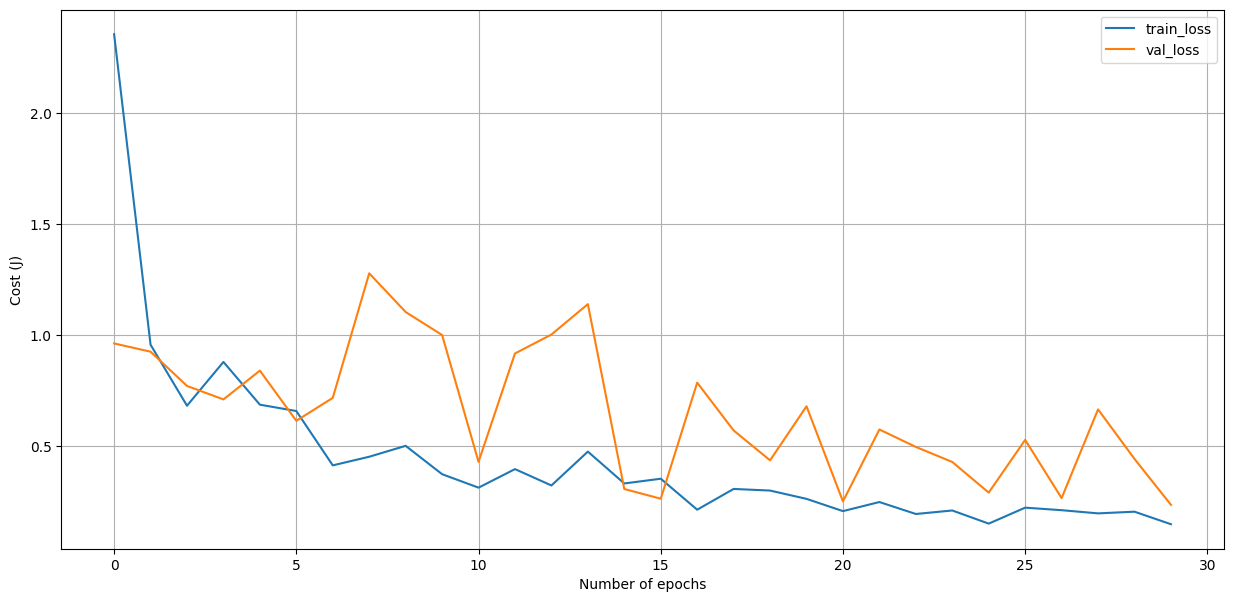

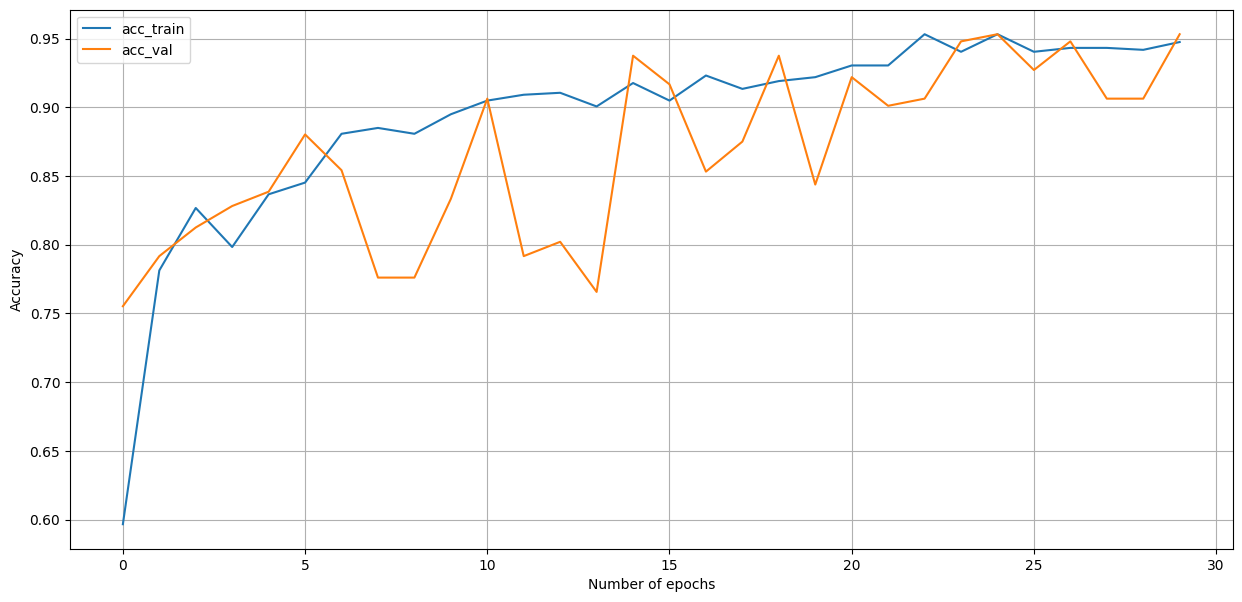

In [ ]:
# Plotting the loss and accuracy graphs

import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))

tr_losses = history_MobileNet.history['loss']
val_losses = history_MobileNet.history['val_loss']

tr_accs = history_MobileNet.history['accuracy']
val_accs = history_MobileNet.history['val_accuracy']

plt.plot(tr_losses, label = "train_loss")
plt.plot(val_losses, label = "val_loss")
plt.xlabel("Number of epochs")
plt.ylabel("Cost (J)")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize = (15,7))

plt.plot(tr_accs, label = "acc_train")
plt.plot(val_accs, label = "acc_val")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

**Model evaluation on test**

In [ ]:
# Model prediction on test set

predictions = model.predict(test_datagen_MobileNet,
                            verbose = 1,
                            steps = (len(test_datagen_MobileNet)))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 422s 270ms/step


In [ ]:
# Printing predicted classes on the test dataset

predictions.squeeze().argmax(axis = -1)

array([0, 0, 0, ..., 2, 2, 2])

In [ ]:
# Generating the classification report for checking the model's performance on the test set of the same dataset

classification__report = classification_report(test_datagen_MobileNet.classes,
                                               predictions.squeeze().argmax(axis = 1))
print(classification__report)

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       491
           1       0.91      0.94      0.92       545
           2       0.98      0.94      0.96       527

    accuracy                           0.94      1563
   macro avg       0.94      0.94      0.94      1563
weighted avg       0.94      0.94      0.94      1563



In [ ]:
# Generating confusion matrix to see where the model is misclassifying

confusion__matrix = confusion_matrix(test_datagen_MobileNet.classes,
                                     predictions.squeeze().argmax(axis = 1))
print(confusion__matrix)

[[461  26   4]
 [ 30 510   5]
 [  6  24 497]]


In [ ]:
# Defining a function to print a confusion matrix
# Code snippet referenced from: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
def plot_confusion_matrix(cm,
                          classes,
                          normalise = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Reds):

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalise:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        cm = cm.round(2)

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

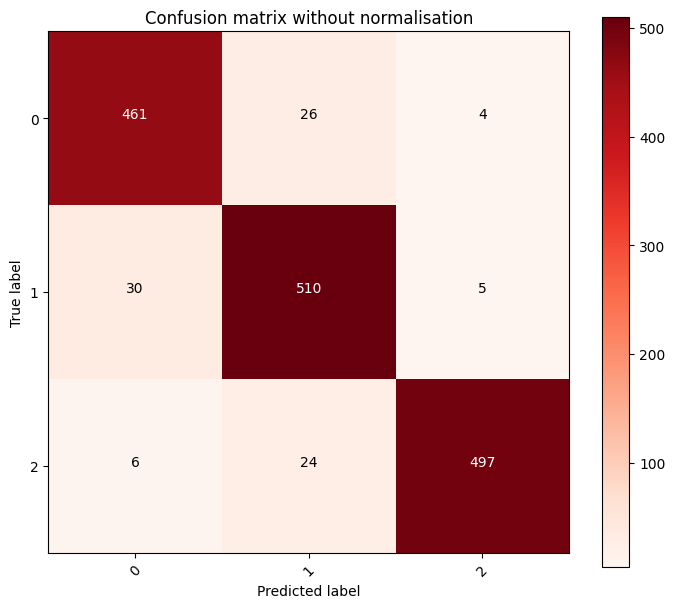

In [ ]:
# Printing the confusion matrix (not normalised)

np.set_printoptions(precision = 2)
fig1 = plt.figure(figsize = (7, 6))
plot_confusion_matrix(confusion__matrix,
                      classes = np.unique(test_datagen_MobileNet.classes),
                      title = 'Confusion matrix without normalisation')
fig1.savefig('/content/drive/MyDrive/OpenCV/Dataset/cm_wo_norm.jpg')
plt.show()

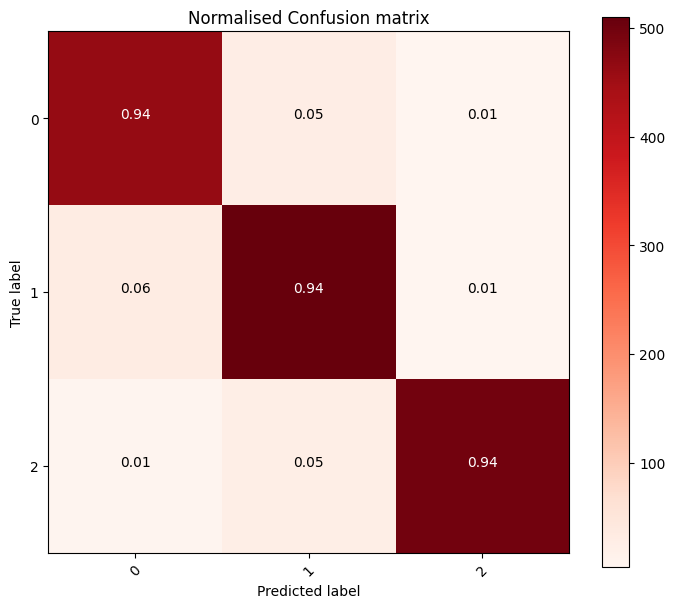

In [ ]:
# Printing the confusion matrix (normalised)

np.set_printoptions(precision = 2)
fig2 = plt.figure(figsize = (7,6))
plot_confusion_matrix(confusion__matrix,
                      classes = np.unique(test_datagen_MobileNet.classes),
                      normalise = True,
                      title = 'Normalised Confusion matrix')
fig2.savefig('Dataset/cm_norm.jpg')
plt.show()